### Setup

EU ETS is simulated for the years 2020-2050. t=0 is 2020, and so t=30 is 2050. Supply and demand is zero from year 2065, by the calibration.

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate a list for time periods t that ranges from 0 to 45. Generate a corresponding list for the years of the scheme.
t = list(range(0, 31))
year = list(map(str, range(2020, 2051)))

# Generate dictionnary
dictionnary = {'t': t, 'year':year}

# Generate Dataframe from dictionnary
df = pd.DataFrame(dictionnary)


### Variables

In [220]:
# Add alpha to the Dataframe
alpha = []

for value in df["t"]:
    if value <= 3:
        alpha.append(0.24)
    if value > 3:
        alpha.append(0.12)
        
df["alpha"] = alpha

# Add supply to the Dataframe
s_t = []

for value in df["t"]:
    s_t.append(1859 - (43.003515)*value)
    
df["s(t)"] = s_t  


### Scalars, Variables and Main Equations

#### Scalars 
r - Interest rate

beta - Threshold for cancellation of allowances (as a fixed share of supply)

p0 - Average price in 2020 (t=0)

d0 - Demand in 2020 (t=0)

apar - Parameter alpha in demand function

bpar - Parameter beta in demand function

#### Variables

p(t) - Price over time

d(t) - Demand 

M(t) - Size of the MSR

B(t) - Banking of allowances

c(t) - Cancellation of allowances

m_in(t) - Inflow of allowances into the MSR

m_out(t) - Outflow out of the MSR

Total_D - Cumulative Demand over all periods

Total_C - Cumulative cancellation of allowances over all periods

#### Main Equations

EQ1: Price over time

EQ2: Demand for allowances

EQ3: Inflow of allowances into the MSR

EQ4: Outflow of allowances from MSR

EQ5: Size of MSR

EQ6: Cancellation of allowances

EQ7: Market balance

In [221]:
# Parameter for beta
beta = 0.57 

# Parameters for demand 
d0 = 1380.2
p0 = 24.76
b_par = 8.492
a_par = d0 + b_par*p0

# Add empty variables to the dataframe
df["p(t)"] = np.nan
df["d(t)"] = np.nan
df["M(t)"] = np.nan
df["B(t)"] = np.nan
df["c(t)"] = np.nan
df["m_in(t)"] = np.nan
df["m_out(t)"] = np.nan

# Set initial values for variables
df.loc[0, 'p(t)'] = 23.8838295
# 23.8838295 EQU PRICE: B(END)=0.
df.loc[0, 'd(t)'] = 0
df.loc[0, 'M(t)'] = 1924
df.loc[0, 'B(t)'] = 1579
df.loc[0:2, 'c(t)'] = 0
df.loc[0, 'm_in(t)'] = 0
df.loc[0, 'm_out(t)'] = 0

# Main Equations
for i in range(1, len(df)):
    df.loc[i, 'p(t)'] = df.loc[i-1, 'p(t)'] * (1 + 0.05)                                                                           # EQ1
    
    df.loc[i, 'd(t)'] = a_par - (b_par * df.loc[i, 'p(t)'])                                                                        # EQ2
    
    df.loc[i, 'm_in(t)'] = max(0, df.loc[i, 'alpha'] * df.loc[i-1, 'B(t)'] * (df.loc[i-1, 'B(t)'] - 833))\
    * (df.loc[i-1, 'B(t)'] - 833) / ((df.loc[i-1, 'B(t)'] - 833) * (df.loc[i-1, 'B(t)'] - 833) + 0.01)                             # EQ3
    
    df.loc[i, 'm_out(t)'] = min(df.loc[i-1, 'M(t)'], (max(0, 100*(400 - df.loc[i-1, 'B(t)'])) * (400 - df.loc[i-1, 'B(t)'])\
                                / ((400 - df.loc[i-1, 'B(t)']) * (400 - df.loc[i-1, 'B(t)']) + 0.01)))                             # EQ4
    
    df.loc[i, 'M(t)'] = df.loc[i-1, 'M(t)'] + df.loc[i, 'm_in(t)'] - df.loc[i, 'm_out(t)'] - df.loc[i-1, 'c(t)']                   # EQ5
    
    if df.loc[i, 't'] > 2:                                                                                                         # EQ6
        df.loc[i, 'c(t)'] = max(0, df.loc[i, 'M(t)'] - 0.57*df.loc[i, 's(t)'])
    else:
        df.loc[i, 'c(t)'] = 0

    df.loc[i, 'B(t)'] = df.loc[i, 's(t)'] - df.loc[i, 'm_in(t)'] + df.loc[i, 'm_out(t)'] - df.loc[i, 'd(t)'] + df.loc[i-1, 'B(t)'] # EQ7

df

,t,year,alpha,s(t),p(t),d(t),M(t),B(t),c(t),m_in(t),m_out(t)
0,0,2020,0.24,1859.000000,23.471429,0.000000,1924.000000,1579.000000,0.000000,0.000000,0.000000
1,1,2021,0.24,1815.996485,24.645000,1381.176580,2302.959993,1634.859912,0.000000,378.959993,-0.000000
2,2,2022,0.24,1772.992970,25.877250,1370.712313,2695.326366,1644.774196,0.000000,392.366373,-0.000000
3,3,2023,0.24,1729.989455,27.171112,1359.724833,3090.072167,1620.293017,2103.978178,394.745801,-0.000000
4,4,2024,0.12,1686.985940,28.529668,1348.187978,1180.529148,1764.655820,218.947162,194.435159,-0.000000
5,5,2025,0.12,1643.982425,29.956152,1336.074281,1173.340682,1860.805268,236.270700,211.758696,-0.000000
6,6,2026,0.12,1600.978910,31.453959,1323.354899,1160.366612,1915.132649,247.808634,223.296630,-0.000000
7,7,2027,0.12,1557.975395,33.026657,1309.999548,1142.373895,1933.292580,254.327919,229.815916,-0.000000
8,8,2028,0.12,1514.971880,34.677990,1295.976430,1120.041083,1920.292922,256.507111,231.995108,-0.000000
9,9,2029,0.12,1471.968365,36.411889,1281.252155,1093.969120,1880.573983,254.947152,230.435149,-0.000000


### Cumulative demand and cancellation of allowances

In [211]:
# Cumulative emissions (demand) in the cap-and-trade scheme)

Total_D = df['d(t)'].sum()
print(Total_D)

33564.87094298904


In [212]:
# Cumulative cancellation of allowances in the scheme

Total_C = df['c(t)'].sum()
print(Total_C)

5711.494579858223


### Figure 1: Market Balance

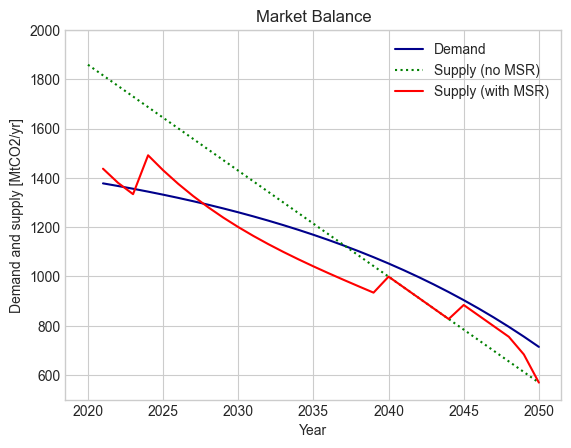

In [214]:
# Add column for 'market balance' in the dataframe
# Balance will be plotted with demande, which will be a similar figure as Figure 2 in Gerlagh et al. (2021).
df["balance"] = np.nan

for i in range(1, len(df)):
        df.loc[i, 'balance'] = df.loc[i, 's(t)'] - df.loc[i, 'm_in(t)'] + df.loc[i, 'm_out(t)']  

df.loc[0, 'd(t)'] = None      

ax = plt.gca()

# Use plot() method on the dataframe
df.plot( x = 'year' , y = 'd(t)', color = "darkblue", ax = ax )
df.plot( x = 'year' , y = 's(t)', linestyle = "dotted", color = "green", ax = ax )
df.plot( x = 'year' , y = 'balance' , color = "red", ax = ax )
plt.ylim((500, 2000))
plt.title('Market Balance')
plt.xlabel('Year')
plt.ylabel('Demand and supply [MtCO2/yr]')
plt.legend(['Demand', 'Supply (no MSR)', 'Supply (with MSR)'])
plt.style.use("seaborn-v0_8-whitegrid")

### Figure 2: Stocks of allowances

Figure that shows the stock of allowances in the MSR for the years 2021-2050, that is, the baseline scenario.

The stock is divided into five separate contents: Banking of allowances (Banking), inflow of allowances this period (MSR-in), allowances that remain in the MSR until next period (MSR-stays), outflow of allowances for next period (MSR-out), and allowances that are cancelled (MSR-cancelled). 

(array([ 0,  5, 10, 15, 20, 25, 30]),
 [Text(0, 0, '2020'),
  Text(5, 0, '2025'),
  Text(10, 0, '2030'),
  Text(15, 0, '2035'),
  Text(20, 0, '2040'),
  Text(25, 0, '2045'),
  Text(30, 0, '2050')])

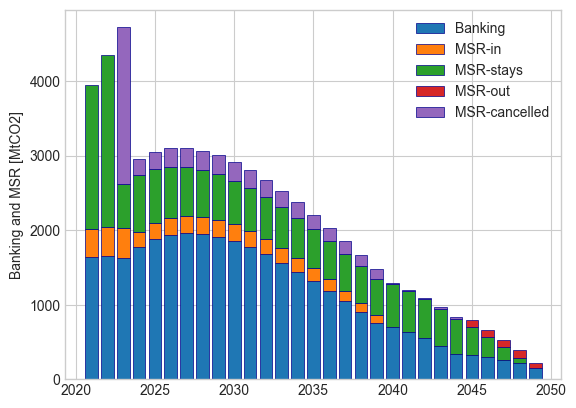

In [218]:
df["msr-stays"] = np.nan

for i in range(1, len(df)):
    df.loc[i, 'msr-stays'] = df.loc[i, 'M(t)'] - df.loc[i, 'm_in(t)'] - df.loc[i, 'c(t)']

df.loc[0, 'M(t)'] = 0
df.loc[0, 'B(t)'] = 0

df.plot.bar( x = 'year', y = ['B(t)', 'm_in(t)', 'msr-stays', 'm_out(t)', 'c(t)'], \
           edgecolor = "darkblue", \
            linewidth = 0.5, width = 0.8, stacked = True)

plt.ylabel("Banking and MSR [MtCO2]")
plt.xlabel(None)
plt.legend(["Banking", "MSR-in", "MSR-stays", "MSR-out", "MSR-cancelled"])
plt.style.use("seaborn-v0_8-whitegrid")
plt.locator_params(axis='x', nbins=7)
plt.xticks(rotation=0)